## Precipitation extremes

In [1]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import spatial_selection
import plotting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
start_date = '1980-01-01'
end_date = '1989-12-31'

In [5]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [6]:
rx1day_files = {}
cdd_files = {}
cwd_files = {}
prcptot_files = {}

In [7]:
rx1day_annual_mean = {}
cdd_annual_mean = {}
cwd_annual_mean = {}

In [8]:
def read_data(infile, regrid=False, time_bounds=None):
    """Read data and calculate annual mean.
    
    Parameters
    ----------
    infile (str)
    regrid (xarray Dataset) - grid to remap to
    time_bounds (list)
    
    """
    
    ds = xr.open_dataset(infile, decode_timedelta=False)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    annual_mean = ds.mean('time', keep_attrs=True)
    if type(regrid) == xr.core.dataset.Dataset:
        regridder = xe.Regridder(ds, regrid, "bilinear")
        annual_mean = regridder(annual_mean)    
    annual_mean = spatial_selection.select_shapefile_regions(annual_mean, aus_shape)    
    annual_mean = annual_mean.compute()
    
    return annual_mean

## rx1day

In [9]:
rx1day_files['AGCD'] = '/g/data/xv83/dbi599/indices/rx1day_year_AGCD_v1_r005_1900-2021.nc'
rx1day_files['ACCESS-CM2'] = '/g/data/xv83/dbi599/indices/rx1day_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc'
rx1day_files['NorESM2-MM'] = '/g/data/xv83/dbi599/indices/rx1day_year_NorESM2-MM_historical_r1i1p1f1_gn_1850-2014.nc'
rx1day_files['BARPA'] = '/g/data/xv83/dbi599/indices/rx1day_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc'

In [10]:
rx1day_annual_mean['AGCD'] = read_data(
    rx1day_files['AGCD'], regrid=False, time_bounds=[start_date, end_date]
)

In [12]:
for model in ['ACCESS-CM2', 'NorESM2-MM', 'BARPA']:
    rx1day_annual_mean[model] = read_data(
        rx1day_files[model], regrid=rx1day_annual_mean['AGCD'], time_bounds=[start_date, end_date]
    )

/g/data/xv83/dbi599/model-evaluation/pr_rx1day_CCAM-NorESM2-MM_1980-01-01_1989-12-31.png


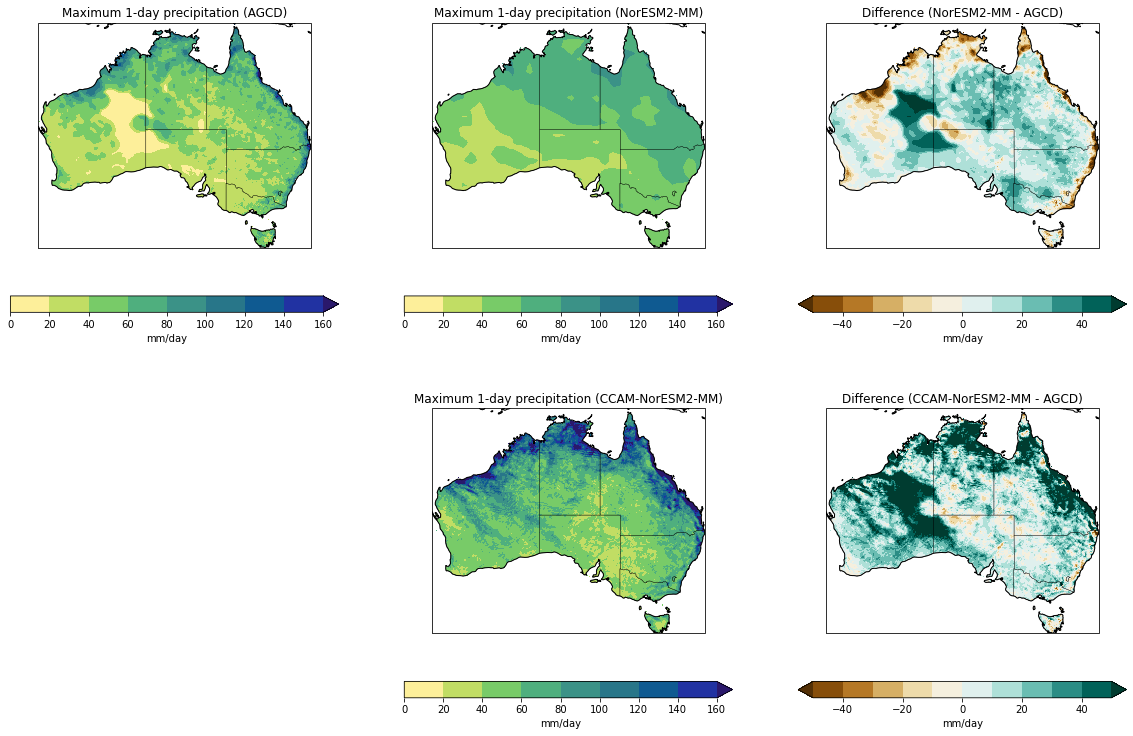

In [13]:
plotting.compare_agcd_gcm_rcm(
    rx1day_annual_mean['AGCD']['RX1day'],
    rx1day_annual_mean['NorESM2-MM']['RX1day'],
    'pr',
    'rx1day',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    [0, 20, 40, 60, 80, 100, 120, 140, 160],
    [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50],
    rcm_da=rx1day_annual_mean['BARPA']['RX1day'],
)

## CDD - Maximum consecutive dry days

In [19]:
cdd_files['AGCD'] = '/g/data/xv83/dbi599/indices/cdd_year_AGCD_v1_r005_1900-2021.nc'
cdd_files['ACCESS-CM2'] = '/g/data/xv83/dbi599/indices/cdd_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc'
cdd_files['NorESM2-MM'] = '/g/data/xv83/dbi599/indices/cdd_year_NorESM2-MM_historical_r1i1p1f1_gn_1850-2014.nc'
cdd_files['BARPA'] = '/g/data/xv83/dbi599/indices/cdd_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc'

In [20]:
cdd_annual_mean['AGCD'] = read_data(
    cdd_files['AGCD'], regrid=False, time_bounds=[start_date, end_date]
)

In [21]:
for model in ['ACCESS-CM2', 'NorESM2-MM', 'BARPA']:
    cdd_annual_mean[model] = read_data(
        cdd_files[model], regrid=cdd_annual_mean['AGCD'], time_bounds=[start_date, end_date]
    )

/g/data/xv83/dbi599/model-evaluation/pr_cdd_CCAM-NorESM2-MM_1980-01-01_1989-12-31.png


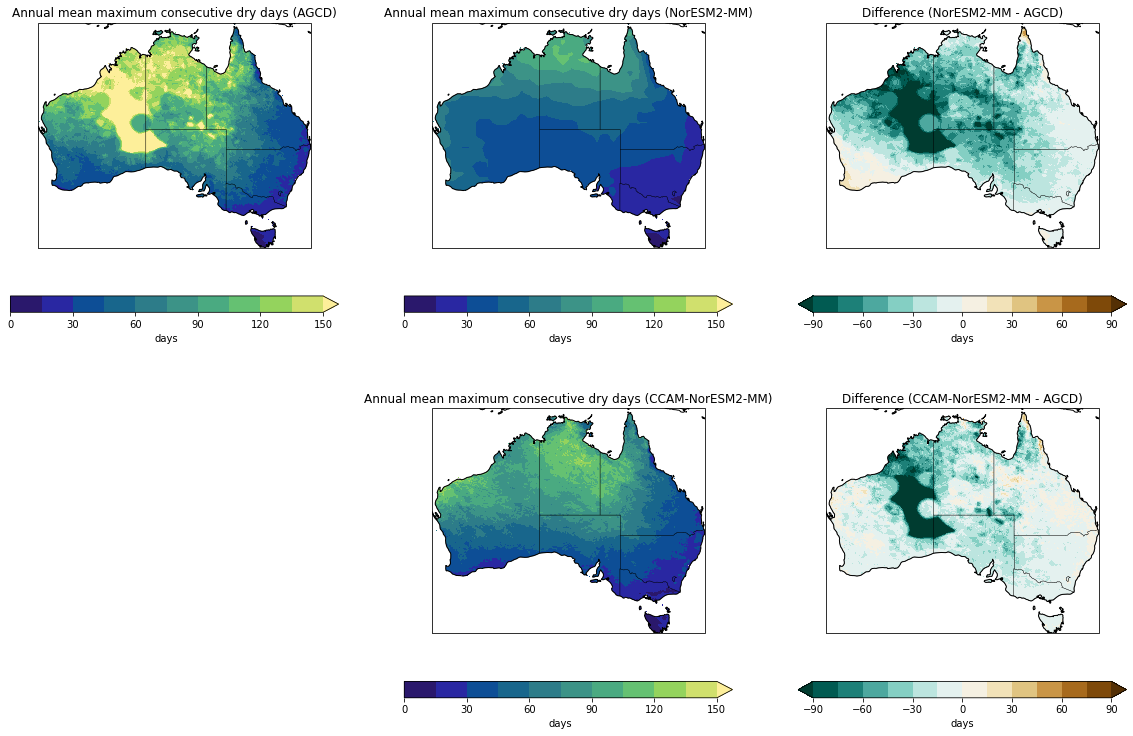

In [22]:
plotting.compare_agcd_gcm_rcm(
    cdd_annual_mean['AGCD']['CDD'],
    cdd_annual_mean['NorESM2-MM']['CDD'],
    'pr',
    'cdd',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150],
    [-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90],
    rcm_da=cdd_annual_mean['BARPA']['CDD'],
)

## CWD - Maximum consecutive wet days

In [23]:
cwd_files['AGCD'] = '/g/data/xv83/dbi599/indices/cwd_year_AGCD_v1_r005_1900-2021.nc'
cwd_files['ACCESS-CM2'] = '/g/data/xv83/dbi599/indices/cwd_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc'
cwd_files['NorESM2-MM'] = '/g/data/xv83/dbi599/indices/cwd_year_NorESM2-MM_historical_r1i1p1f1_gn_1850-2014.nc'
cwd_files['BARPA'] = '/g/data/xv83/dbi599/indices/cwd_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc'

In [24]:
cwd_annual_mean['AGCD'] = read_data(
    cwd_files['AGCD'], regrid=False, time_bounds=[start_date, end_date]
)

ValueError: unable to decode time units 'days since 1900-01-01 00:00:00' with "calendar 'proleptic_gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

TODO: I might need to consider dropping the time bounds variable before writing out the index files.